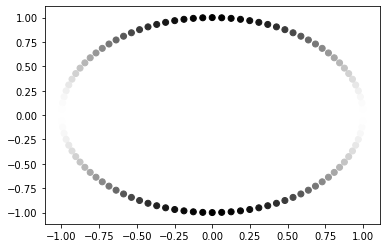

In [65]:
import numpy as np
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
import matplotlib.pyplot as plt

#Our cost function requires a symmetric nxn matrix A. One such A is initialised(random infact). 
# (cos theta, sin theta)^T A (cos theta, sin theta) === (cos^2 theta - sin^2 theta)
# minimum at theta = pi / 2
# (1, 1)
A = np.array([[1, 0], [0, -1]], dtype=np.float)


# This is essentially Rayleigh quotient minimization , x->x.TAx where A=symmetric 4x4 matrix
def field(x):
    return x.T @ A @ x# np.matmul(np.transpose(x), np.matmul(A,x))

def field_2d(x, y):
    return field(np.array([x, y]))

def plot_field():
    NPOINTS = 100
    PRECISION = 4
    P = np.zeros((NPOINTS, 2))
    Z = np.zeros(NPOINTS)
    for i in range(NPOINTS):
        P[i][0] = np.round(np.cos(i * (2 * np.pi / NPOINTS)), PRECISION)
        P[i][1] = np.round(np.sin(i * (2 * np.pi / NPOINTS)), PRECISION)
        Z[i] = field_2d(P[i][0], P[i][1])
    plt.scatter(P[:, 0], P[:, 1], c=Z, cmap='gray')
    
plot_field()

We can now see the function we are interested in optimising. The optima lies at $(\pm 1, 0)$.

`x_cur` is a random initial value to start the line search algorithm on the manifold $S^1$ which is realised as a submanifold of $\mathbb R^2$.

That is, we are optimising over a circle that is embedded in 2D using $\theta \mapsto (\cos \theta, \sin \theta)$.

Our step size calculation would be based on a concept called Armijo point. 
Armijo point requires the selection of scalars $\alpha > 0$, and
$\beta, \sigma \in (0, 1)$. These have also been randomly intialised for now. 
They will be tweaked later for better convergence.

In [66]:
alpha, beta, sigma = [3, 0.2, 0.05] 

The retraction which is a function that maps the manifold to itself. 
The retraction we have used takes two vectors $\vec x$, $\vec \tau$ as arguments and returns 
$\frac{x + \tau}{|x + \tau|}$. That is, the direction of the vector $x + \tau$.

In [67]:
def retraction(x_cur, tau):
    z = x_cur + tau
    absval = np.linalg.norm(z, 2)
    return np.divide(z, absval)

We are trying to optimise $F(x) = x^T A x : \mathbb R^2 \rightarrow \mathbb R$.

At the point $p$ on the manifold $S^1$, we have a tangent space $T_p S^1$. This $T_p S^1$ can be identified with $\mathbb R^2$ using the embedding. 

We now create a space of normal vectors
$T_p \overline{S^1} \equiv \left\{ \xi \in \mathbb R^2 \mid \xi^T x = 0 ~ \forall x \in T_p S^1 \right\}$.  


Now, given any vector $\alpha \in \mathbb R^2$, we can consider how this vector $\alpha$ can be split into a component along $T_p S^1$ and a component along $T_p \overline {S^1}$. These components are given by the projction operators $P_x: \mathbb R^2 \rightarrow T_x S^1$ and $P_x^\bot : \mathbb R^2 \rightarrow T_x \bar{S^1}$.

Things to notice:

- The dimension of our space $T_x M$ is $1$ since we are on a circle
- The dimension of $T_x \overline{M}$ is also $1$ since it is the directions _perpendicular_ to the circle in $\mathbb R^2$.
- At each point $\vec p \in S^1 \subset \mathbb R^2$, for the space $T_x \overline{M}$ the vector $\vec p$ forms an _orthonormal basis_ for $T_x \overline{M}$. This is because for any point on the sphere, $|\vec p| = 1$ and is therefore normalized. Since the dimension of the space $T_x \overline M$ is $1$, $\vec p$  is a basis. From these two conditions, it is orthonormal.

- We will consider the function $f: S^1 \rightarrow \mathbb R$ as a function  $\overline f: \mathbb R^2 \rightarrow \mathbb R$. Then, we only consider the gradient which is _along our tangent space_. The way in which we compute this is by using the fact that:

\begin{align*}
 D_x \overline{f} [ \zeta ] = \zeta^T A x + x^T A \zeta = 2 \zeta^T A x
\end{align*}

where $D_x \overline{f}$ stands for the gradient of the function at $x$ _with respect to the ambient space_ $\mathbb R^2$.

We now need to "lower" the gradient evaluated from the ambient space $\mathbb R^2$ down into the circle $S^1$.

The way we will do this is to write the gradient as a combination of the components along $T_x M$ and components along $T_x \overline{M}$. These two spaces together span $\mathbb R^2$. That is, $T_x \mathbb R^2 = T_x S^1 \oplus T_x \overline{S^1}$.

Hence, the tangent vector $\vec p \in \mathbb T_x R^2$ along $T_x \overline S^1$ is $ x x^T p$.
So, the vector along $T_x S^1 = (I - xx^T)p$.

Taking the gradient $D_x \overline{f}$ along the vector space $T_x$ gives us:
\begin{align*}
(\text{projection on $T_x M$}) (\text{gradient of $f$ at $x$}) = 
(I - xx^T) (2 A x) = 2 (A x - x x^T A x)
\end{align*}

gradient at theta = 0.0: [0. 0.] 
gradient at theta = 90.0: [2.4492936e-16 0.0000000e+00] 
gradient at theta = 45.0: [ 1.41421356 -1.41421356] 


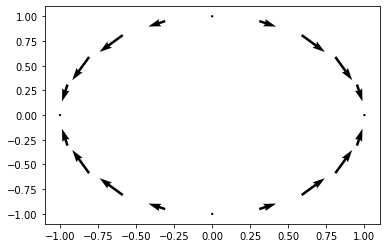

In [90]:
#Gradient is calculated as 2*(Ax_k − x_k x_k.T A x_k) .
def gradient(x_cur):
    return 2* (A @ x_cur - x_cur * field(x_cur))

def dbg_gradient_at_theta(theta_rad):
    v = np.array([np.cos(theta_rad), np.sin(theta_rad)], dtype=np.float)
    print("gradient at theta = %s: %s " % (theta_rad * 180 / np.pi, gradient(v)))
    

def dbg_plot_gradients():
    NPOINTS = 20
    PRECISION = 4
    P = np.zeros((NPOINTS, 2))
    TV = np.zeros((NPOINTS, 2))
    for i in range(NPOINTS):
        P[i][0] = np.round(np.cos(i * (2 * np.pi / NPOINTS)), PRECISION)
        P[i][1] = np.round(np.sin(i * (2 * np.pi / NPOINTS)), PRECISION)
        TV[i] = gradient(P[i])
    plt.quiver(P[:, 0], P[:, 1], TV[:, 0], TV[:, 1])

    
# gradient is 0 since this is a maxima
dbg_gradient_at_theta(0.0)
# gradient is 0 since this is a minima
dbg_gradient_at_theta(np.pi/ 2)
dbg_gradient_at_theta(np.pi/4)
dbg_plot_gradients()

final xs:
[[ 0.5         0.5       ]
 [-0.58123819  0.81373347]
 [ 0.22637603  0.97403999]
 [ 0.1225992   0.99245626]
 [ 0.06452614  0.99791602]
 [ 0.03366647  0.99943312]
 [ 0.0175226   0.99984647]
 [ 0.00911401  0.99995847]]


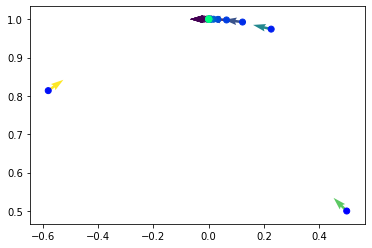

In [142]:
'''Find the smallest integer m ≥ 0 such that
f (Rx_k (aplha.beta^m eta_k )) ≤ f(x_k) − sigma.alpha.beta^m eta_k.T eta_k'''
# Definition 4.2.2 (Armijo point) from Optimisation on matrix manifolds
def armijo_step(x_cur):
    m = 0
    while True:
        # we choose eta as negative of gradient:
        eta = -1.0 *  gradient(x_cur)
        r = retraction(x_cur, alpha*(beta**m)*eta)
        dot = (-1.0 * sigma * gradient(x_cur)) @ ((beta **m) * alpha * eta)
        if field(x_cur) - field(r) >= dot:
            return alpha*(beta**m)
        m += 1
        

#The updation happens in this loop for 10000 iterations
# returns list of x_cur and eta_ks
def run_gradient_descent():
    x_cur = np.array((0.5, 0.5), dtype=float)
    XS = [x_cur]
    ETAS = []
    i = 0
    while i <= 1000:
        #eta_k is chosen as -grad f(x_k) which is gradient-related
        eta_k = -1.0 * gradient(x_cur)
        ETAS.append(eta_k)
        if np.linalg.norm(eta_k) < 1e-4: break
        
        t_k = armijo_step(x_cur)
        x_cur = retraction(x_cur, t_k*eta_k)
        XS.append(x_cur)
        i += 1
    return (np.array(XS), np.array(ETAS))

def dbg_plot_gradient_descent(xs, etas):
    nvecs = xs.shape[0]
    lens = np.linalg.norm(etas, axis=1)
    for i in range(lens.shape[0]):
        etas[i] =  etas[i] / lens[i]

    plt.quiver(xs[:nvecs, 0], xs[:nvecs, 1], etas[:nvecs, 0], etas[:nvecs, 1], lens)
    plt.scatter(xs[:, 0], xs[:, 1], c=np.arange(nvecs), cmap='winter')

xs, etas = run_gradient_descent()
print("final xs:")
print(xs[:-10])
dbg_plot_gradient_descent(xs, etas)